# <center> Anamoly Detection </center>

___

We will use a subset of Kaggle Dataset - [Credit card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv). 

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 fraudss out of 100,000 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.4% of all transactions.

Features V1, V2, ... V28 are the principal components obtained with PCA, the only feature which has not been transformed with PCA is 'Amount'. 
- Feature 'Amount' is the transaction Amount.
- Feature 'Class' is the response variable and it takes <b>value 1 in case of fraud and 0 otherwise</b>.

### OBJECTIVE : Identify fraudulent credit card transactions using Autoencoders.

#### We will train the autoencoder model only for normal transactions. The idea is that a model trained on normal transactions will give high error on fraud transactions.

___

### Load required libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, Dropout
from keras.models import Model

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Reading the data

In [2]:
data = pd.read_csv("Fraud_data_amtstd.csv")

### Understand the data

#### Display No. of records and attributes 

In [3]:
data.shape

(100000, 30)

#### Look at first 5 records

In [4]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.836500,-0.545419,-0.462979,0.537174,-0.426143,-0.100606,-0.584764,-0.103956,2.268429,-0.365185,...,0.085111,0.410736,0.137625,0.602906,-0.350260,0.464407,-0.070917,-0.030486,0.049882,0
1,-4.289880,-2.576061,-0.092256,1.976405,2.810033,-2.669128,-0.981883,-0.470310,-0.025692,0.099528,...,-0.473240,-0.307295,-2.789549,0.578976,-0.837979,0.372843,0.353451,-1.662202,-0.347171,0
2,1.131318,0.139818,0.586921,1.069291,-0.334908,-0.204938,-0.135526,0.043821,-0.121117,0.182139,...,-0.028126,-0.167062,-0.048054,-0.009912,0.417694,-0.479793,0.024360,0.023878,-0.208963,0
3,-0.866956,1.373947,1.948343,2.686750,-0.366790,0.568632,-0.278349,0.739536,-1.655955,0.708396,...,0.022719,-0.070619,-0.080307,0.000816,0.092167,0.159131,0.157940,-0.014370,-0.253595,0
4,-0.842670,1.401843,0.927235,1.070402,0.843883,0.467333,0.366716,0.616739,-1.586963,0.000041,...,0.036573,-0.182581,-0.226834,-1.029794,-0.118762,-0.228960,-0.024250,0.046547,-0.346230,0


#### Display column names

In [5]:
data.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

#### Data type of each attribute

In [6]:
data.dtypes

V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

### Data distribution w.r.t target attributes

In [7]:
print(pd.value_counts(data['Class']))

print(pd.value_counts(data['Class'])*100/data['Class'].shape[0])

0    99508
1      492
Name: Class, dtype: int64
0    99.508
1     0.492
Name: Class, dtype: float64


#### Bar plot

Text(0, 0.5, 'Frequency')

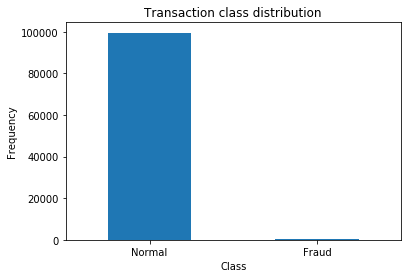

In [8]:
# Drawing a barplot
pd.value_counts(data['Class']).plot(kind = 'bar', rot=0)

# Giving titles and labels to the plot
plt.title("Transaction class distribution")
plt.xticks(range(2), ["Normal", "Fraud"])
plt.xlabel("Class")
plt.ylabel("Frequency")

## Train test split

- Seperate out fraud and non-fraud data.
- Split the non-fraud into train and test

In [9]:
data_nf = data[data.values[:, -1] == 0]
test_f  = data[data.values[:, -1] == 1]

train_nf, test_nf = train_test_split(data_nf, test_size=0.2, 
                                     random_state=123)

#### Look at the distribution w.r.t target attribute

In [10]:
print(np.unique(data.Class, return_counts=True))
print(np.unique(train_nf.Class, return_counts=True))
print(np.unique(test_nf.Class, return_counts=True))
print(np.unique(test_f.Class, return_counts=True))

(array([0, 1]), array([99508,   492]))
(array([0]), array([79606]))
(array([0]), array([19902]))
(array([1]), array([492]))


#### Only extract independent features

In [11]:
X_train_nf = train_nf.loc[:, train_nf.columns!='Class']

X_test_nf = test_nf.loc[:, test_nf.columns!='Class']

X_test_f = test_f.loc[:, test_f.columns!='Class']

## Autoencoder Model

In [12]:
input_dim = X_train_nf.shape[1]
print(input_dim)

encoding_dim = 20

29


In [13]:
# Input placeholder
input_att = Input(shape=(input_dim,))

input_dropout = Dropout(0.1)(input_att)
 
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_dropout)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='linear')(encoded)

In [14]:
autoencoder = Model(input_att, decoded)

#### Compile the model

In [15]:
autoencoder.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy'])

#### Fit the model

In [16]:
autoencoder.fit(X_train_nf, X_train_nf, epochs=100, 
                validation_split=0.2)

Train on 63684 samples, validate on 15922 samples
Epoch 1/100
63684/63684 [==============================] - 3s 48us/step - loss: 0.5876 - acc: 0.4754 - val_loss: 0.2250 - val_acc: 0.7237
Epoch 2/100
63684/63684 [==============================] - 3s 41us/step - loss: 0.2409 - acc: 0.7265 - val_loss: 0.1177 - val_acc: 0.8625
Epoch 3/100
63684/63684 [==============================] - 3s 40us/step - loss: 0.1861 - acc: 0.7933 - val_loss: 0.0970 - val_acc: 0.9056
Epoch 4/100
63684/63684 [==============================] - 3s 44us/step - loss: 0.1736 - acc: 0.8188 - val_loss: 0.0908 - val_acc: 0.9230
Epoch 5/100
63684/63684 [==============================] - 3s 45us/step - loss: 0.1699 - acc: 0.8224 - val_loss: 0.0897 - val_acc: 0.9229
Epoch 6/100
63684/63684 [==============================] - 3s 47us/step - loss: 0.1741 - acc: 0.8213 - val_loss: 0.0940 - val_acc: 0.9102
Epoch 7/100
63684/63684 [==============================] - 3s 46us/step - loss: 0.1682 - acc: 0.8247 - val_loss: 0.0890 - 

#### Evaluate the loss on non-fraud train data

In [17]:
autoencoder.evaluate(X_train_nf, X_train_nf)

79606/79606 [==============================] - 2s 22us/step


[0.08836232554004189, 0.9174936562525736]

#### Evaluate the loss on non-fraud test data

In [18]:
autoencoder.evaluate(X_test_nf, X_test_nf)

19902/19902 [==============================] - 0s 19us/step


[0.09027588934622725, 0.91412923324888]

#### Evaluate the loss on fraud test data

In [19]:
autoencoder.evaluate(X_test_f, X_test_f)

492/492 [==============================] - 0s 25us/step


[18.8483804474032, 0.4532520330049158]

#### Function to calculate mse for each record

In [20]:
def mse_for_each_record(act, pred):
    
    return np.mean(np.square(act - pred), axis=1)

#### Making predictions on the non-fraud train data

In [21]:
pred_train_nf = autoencoder.predict(X_train_nf)

mse_train_nf = mse_for_each_record(X_train_nf, pred_train_nf)

In [22]:
mse_train_nf

1259     0.027043
34243    0.179701
95369    0.036412
45833    0.025008
10804    0.038884
           ...   
63511    0.036797
61701    0.092500
17822    0.038281
28175    0.053311
15804    0.023333
Length: 79606, dtype: float64

In [23]:
np.mean(mse_train_nf)

0.0883623253419994

#### Making predictions on the non-fraud test data

In [24]:
pred_test_nf = autoencoder.predict(X_test_nf)

mse_test_nf = mse_for_each_record(X_test_nf, pred_test_nf)

#### Making predictions on the fraud test data

In [25]:
pred_test_f = autoencoder.predict(X_test_f)

mse_test_f = mse_for_each_record(X_test_f, pred_test_f)

## Explore and identify right cut-off 

### MSE Comparisionbox plot : Non - Fraud Train vs Non - Fraud Test vs Fraud Test 

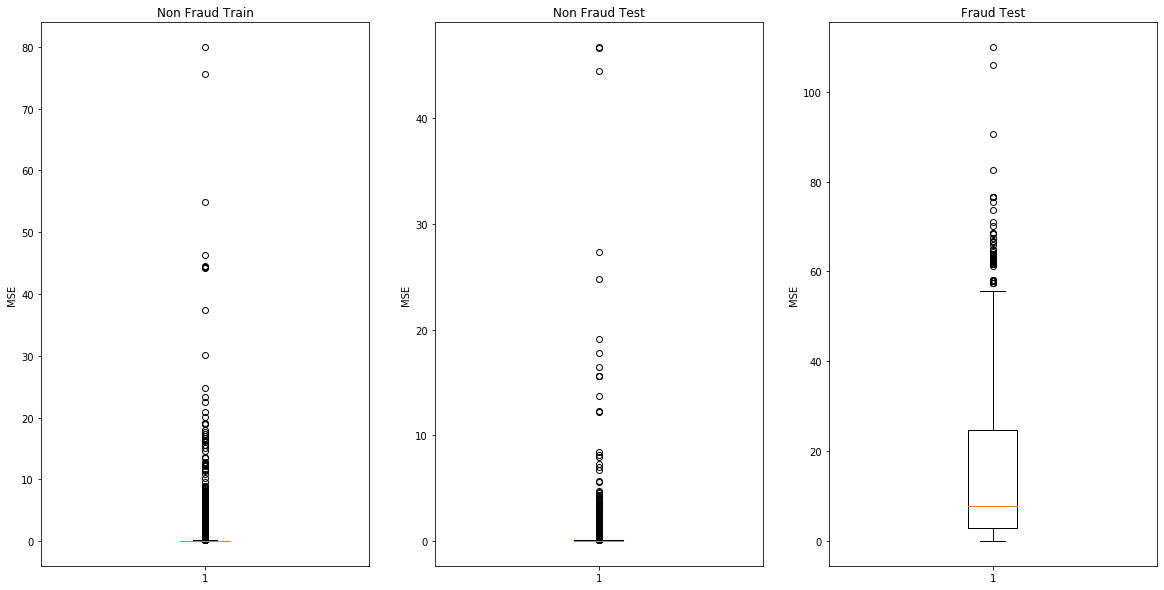

In [26]:
plt.figure(figsize=(20,10))

plt.subplot(1, 3, 1)
plt.boxplot(mse_train_nf)
plt.title("Non Fraud Train")
plt.ylabel("MSE")

plt.subplot(1, 3, 2)
plt.boxplot(mse_test_nf)
plt.title("Non Fraud Test")
plt.ylabel("MSE")

plt.subplot(1, 3, 3)
plt.boxplot(mse_test_f)
plt.title("Fraud Test")
plt.ylabel("MSE")

plt.show()

#### Summary statistics on mse of non-fraud train, non-fraud test and fraud test data 

In [27]:
print("-------mse_train_nf-------")
print(pd.Series(mse_train_nf).describe())
print("\n-------mse_test_NF-------")
print(pd.Series(mse_test_nf).describe())
print("\n-------mse_test_f-------")
print(pd.Series(mse_test_f).describe())

-------mse_train_nf-------
count    79606.000000
mean         0.088362
std          0.729728
min          0.002783
25%          0.019596
50%          0.034917
75%          0.062247
max         79.989367
dtype: float64

-------mse_test_NF-------
count    19902.000000
mean         0.090276
std          0.743060
min          0.003495
25%          0.019599
50%          0.034644
75%          0.062755
max         46.725792
dtype: float64

-------mse_test_f-------
count    492.000000
mean      18.848381
std       23.724699
min        0.009628
25%        2.853327
50%        7.766299
75%       24.612681
max      109.942586
dtype: float64


### Observations :

- Mean error for Fraud Test is much high than others.

In [28]:
np.percentile(mse_train_nf, 80)

0.07208331890255916

In [29]:
np.percentile(mse_test_f, 10)

0.049783062336318525

In [30]:
np.percentile(mse_train_nf, 99)

0.8155131343101705

In [46]:
np.percentile(mse_test_f, 18)

0.8150151001001563

#### Decide cut-off

In [32]:
cut_off = np.round(np.percentile(mse_train_nf,99), 2)

print("Cut-off = {}".format(cut_off))

Cut-off = 0.82


#### % of correctly predicted non-fraud train, non-fraud test and fraud test records

In [33]:
print("Non-fraud train records = {}%".format(np.round(np.sum(mse_train_nf <= cut_off)/train_nf.shape[0],2)*100))
print("Non-fraud test records  = {}%".format(np.round(np.sum(mse_test_nf <= cut_off)/test_nf.shape[0],2)*100))
print("Fraud test records      = {}%".format(np.round(np.sum(mse_test_f > cut_off)/test_f.shape[0],2)*100))

Non-fraud train records = 99.0%
Non-fraud test records  = 99.0%
Fraud test records      = 81.0%
